# RQ5: Test Case Generation

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
TCG_EXPERIMENT_PATH = "../AutonomicTester/experiment_results/testcases/20241203_082121_OpenAI GPT-3.5 Fine-tuned_Defects4J_buggy"
COVERAGE_PATH = os.path.join(TCG_EXPERIMENT_PATH, "coverage_comparison.csv")
STATS_PATH = os.path.join(TCG_EXPERIMENT_PATH, "statistics.csv")
TESTEXE_PATH = os.path.join(TCG_EXPERIMENT_PATH, "test_execution.csv")

In [3]:
df_stats = pd.read_csv(STATS_PATH)
df_testexe = pd.read_csv(TESTEXE_PATH)
df_coverage = pd.read_csv(COVERAGE_PATH)

In [4]:
# Summarize test case generation statistics
df_stats = df_stats[df_stats["miss_location"] == False]
print(f"There are {len(df_stats)} bugs with accessible trigger tests in total.")

There are 673 bugs with accessible trigger tests in total.


In [5]:
df_need_syntax_fix = df_stats[df_stats["#syntax_fix_times"] > 0]
print(f"{len(df_need_syntax_fix)} tests need syntax fix.")

29 tests need syntax fix.


In [6]:
df_valid_syntax = df_stats[df_stats["has_valid_syntax"] == True]
print(f"{len(df_valid_syntax)} tests have valid syntax.")

667 tests have valid syntax.


In [7]:
df_valid_syntax_fix = df_valid_syntax[df_valid_syntax["#syntax_fix_times"] > 0][
    "#syntax_fix_times"
].describe()
print(
    "{count_syntax_retry:.0f} generated tests require retries to fix syntax errors".format(
        count_syntax_retry=df_valid_syntax_fix["count"]
    )
)
print(
    "Average number of retries to fix syntax errors: {mean_syntax_retry:.1f}".format(
        mean_syntax_retry=df_valid_syntax_fix["mean"]
    )
)

23 generated tests require retries to fix syntax errors
Average number of retries to fix syntax errors: 2.1


In [8]:
df_fail_syntax_fix = df_need_syntax_fix[df_need_syntax_fix["has_valid_syntax"] == False]
num_fail_syntax_fix = len(df_fail_syntax_fix)
print(f"{num_fail_syntax_fix} tests fail to fix syntax errors after 5 retries.")

6 tests fail to fix syntax errors after 5 retries.


In [9]:
df_compile = df_stats[
    (df_stats["has_valid_syntax"] == True) & (df_stats["can_compile"] == True)
]
print(f"{len(df_compile)} tests can compile.")

580 tests can compile.


In [10]:
print(
    len(df_compile[df_compile["#compilation_fix_times"] > 0]),
    "tests require retry to fix compilation error",
)

151 tests require retry to fix compilation error


In [11]:
df_compile_fix = df_compile[df_compile["#compilation_fix_times"] > 0][
    "#compilation_fix_times"
].describe()
print(
    "{count_retry:.0f} generated tests require retries to fix compilation errors".format(
        count_retry=df_compile_fix["count"]
    )
)
print(
    "Average number of retries to fix compilation errors: {mean_retry:.1f}".format(
        mean_retry=df_compile_fix["mean"]
    )
)

151 generated tests require retries to fix compilation errors
Average number of retries to fix compilation errors: 1.8


In [12]:
df_need_compile_fix = df_stats[df_stats["#compilation_fix_times"] > 0]
print(len(df_need_compile_fix), "tests need compilation fix.")

244 tests need compilation fix.


In [13]:
num_fail_compile_fix = len(
    df_need_compile_fix[
        (df_need_compile_fix["has_valid_syntax"] == True)
        & (df_need_compile_fix["can_compile"] == False)
    ]
)
print(
    f"{num_fail_compile_fix} tests fail to fix compilation errors after 5 retries.",
)

87 tests fail to fix compilation errors after 5 retries.


In [14]:
df_failure = df_stats[
    (df_stats["has_valid_syntax"] == True)
    & (df_stats["can_compile"] == True)
    & (df_stats["#failing_tests"] > 0)
]
print(len(df_failure), "tests can trigger a failure.")

562 tests can trigger a failure.


In [15]:
df_assert_fix = df_failure[df_failure["#assertion_fix_times"] > 0][
    "#assertion_fix_times"
].describe()
print(
    "{count_retry:.0f} generated tests require retries to fix assertion errors".format(
        count_retry=df_assert_fix["count"]
    )
)
print(
    "Average number of retries to fix assertion errors: {mean_retry:.1f}".format(
        mean_retry=df_assert_fix["mean"]
    )
)

85 generated tests require retries to fix assertion errors
Average number of retries to fix assertion errors: 1.1


In [16]:
df_fail_syntax_fix = df_stats[
    (df_stats["has_valid_syntax"] == True)
    & (df_stats["can_compile"] == True)
    & (df_stats["#failing_tests"] == 0)
]
num_fail_assert_fix = len(df_fail_syntax_fix)

In [17]:
df_test_coverage = (
    df_failure.set_index(["project_id", "bug_id"])
    .join(df_coverage.set_index(["project_id", "bug_id"]))["coverage"]
    .value_counts()
)
num_identical_coverage = df_test_coverage["identical"]
num_higher_coverage = df_test_coverage["higher"]
num_lower_coverage = df_test_coverage["lower"]

In [18]:
test_case_numbers = [
    num_fail_syntax_fix,
    num_fail_compile_fix,
    num_fail_assert_fix,
    num_lower_coverage,
    num_identical_coverage,
    num_higher_coverage,
]

In [19]:
test_case_numbers

[6, 87, 18, np.int64(2), np.int64(553), np.int64(7)]

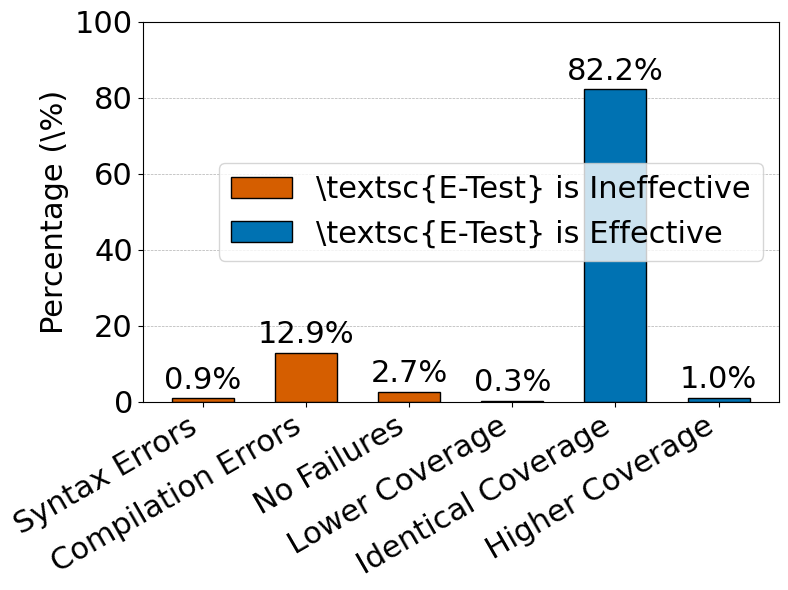

In [20]:
# plt.rcParams.update({"text.usetex": True, "font.family": "Times New Roman"})

# Data for each category (percentages)
categories = [
    "Syntax Errors",
    "Compilation Errors",
    "No Failures",
    "Lower Coverage",
    "Identical Coverage",
    "Higher Coverage",
]
numbers = [6, 87, 18, 2, 553, 7]
total_sum = sum(numbers)
percentages = np.array(numbers) / total_sum * 100

fontsize_paper = 22

# X positions for the categories
x = np.arange(len(categories))

# Colorblind-friendly colors (from Color Universal Design)
incorrect_color = "#D55E00"  # Orange for Incorrect categories
correct_color = "#0072B2"  # Blue for Correct categories

fig, ax = plt.subplots(figsize=(8, 6))

# Plot bars for Incorrect categories (first three)
incorrect_indices = [0, 1, 2, 3]
ax.bar(
    x[incorrect_indices],
    [percentages[i] for i in incorrect_indices],
    color=incorrect_color,
    edgecolor="black",
    width=0.6,
    label=r"\textsc{E-Test} is Ineffective",
)

# Plot bars for Correct categories (last two)
correct_indices = [4, 5]
ax.bar(
    x[correct_indices],
    [percentages[i] for i in correct_indices],
    color=correct_color,
    edgecolor="black",
    width=0.6,
    label=r"\textsc{E-Test} is Effective",
)

# Configure x-axis with category labels
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=30, ha="right", fontsize=fontsize_paper)

# Set y-axis limits and label
ax.set_ylim(0, 100)
ax.set_ylabel("Percentage (\%)", fontsize=fontsize_paper)
ax.tick_params(axis="y", labelsize=fontsize_paper)

# Add horizontal grid lines
ax.yaxis.grid(True, linestyle="--", linewidth=0.5)
ax.set_axisbelow(True)

# Annotate bars with their percentage (skip zeros)
for i, v in enumerate(percentages):
    if v != 0:
        ax.text(
            x[i], v + 1, f"{v:.1f}%", ha="center", va="bottom", fontsize=fontsize_paper
        )

# Add legend
ax.legend(fontsize=fontsize_paper)

plt.tight_layout()
plt.savefig("images/RQ5_barplot.pdf", format="pdf")